# Preprocessing Techniques on Data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style for plots
plt.style.use("seaborn-v0_8")

data = pd.read_csv("../data/star_classification.csv")
print(f"Dataset dimensions: {data.shape}")

Dataset dimensions: (99999, 11)


## 1 Removing Outliers

To remove outliers, we applied the empirical method proposed by Beck et al, which is based on specific intervals defined by combinations of photometric variables. These relations rely on color differences between filters and, in the original formulation, incorporate the measurement uncertainties of each magnitude. Since our dataset does not include error columns, the uncertainty-dependent cuts were not applied. The retained empirical color constraints were:

\begin{align*}
-0.911 &< (u - g) < 5.597, \\
0.167  &< (g - r) < 2.483, \\
0.029  &< (r - i) < 1.369, \\
-0.452 &< (i - z) < 0.790.
\end{align*}

R. Beck, L. Dobos, T. Budavári, A. S. Szalay, and I. Csabai, “Photometric redshifts for the SDSS Data Release 12,” Monthly Notices of the Royal Astronomical Society, vol. 460, no. 2, pp. 1371–1381, 2016.

In [50]:
# Create photometric relationship columns
data['u_g'] = data['u'] - data['g']
data['g_r'] = data['g'] - data['r']
data['r_i'] = data['r'] - data['i']
data['i_z'] = data['i'] - data['z']

# Keep the QSO and STAR samples
other_data = data[data['class'] != 'GALAXY']

# Apply photometric cuts in galaxies
filtered_data = data[
    (data['u_g'] > -0.911) & (data['u_g'] < 5.597) &
    (data['g_r'] > 0.167) & (data['g_r'] < 2.483) &
    (data['r_i'] > 0.029) & (data['r_i'] < 1.369) &
    (data['i_z'] > -0.452) & (data['i_z'] < 0.790) &
    (data['class'] == "GALAXY")
].copy()

# Join again GALAXY, QSO and STAR samples, then shuffle them. 
filtered_data = pd.concat([filtered_data, other_data], ignore_index=True)
filtered_data = filtered_data.sample(len(filtered_data), random_state=42)

# Results
print("Previous total observations:", len(data))
print("Observations after cuts:", len(filtered_data))
print("Removed galaxies:", len(data) - len(filtered_data))

# Remove relation columns
filtered_data.drop(
    ["u_g", "g_r", "r_i", "i_z"],
    axis=1,
    inplace=True
)

filtered_data.reset_index(drop=True, inplace=True)
filtered_data

Previous total observations: 99999
Observations after cuts: 92303
Removed galaxies: 7696


,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD
0,177.187058,-2.078864,19.48917,17.87901,17.06806,16.66376,16.35079,GALAXY,0.103041,330,52370
1,232.828858,1.925923,25.80128,22.44533,21.05690,20.06648,19.52078,GALAXY,0.558141,4054,55358
2,16.593784,6.990476,21.52559,21.06099,20.44481,20.26054,20.31507,QSO,1.273338,11072,58436
3,224.412732,50.408772,17.43231,16.08763,15.51111,15.13761,14.90999,GALAXY,0.065335,1329,52767
4,215.046146,20.446311,18.51887,16.66200,15.71365,15.28103,14.93373,GALAXY,0.075291,2773,54533
...,...,...,...,...,...,...,...,...,...,...,...
92298,205.217611,-0.087243,21.12737,19.17034,17.75006,17.23418,16.87053,GALAXY,0.235709,299,51671
92299,131.487542,54.283483,17.61889,16.58748,16.18591,16.05365,16.00755,STAR,0.000262,2316,53757
92300,123.488967,41.823078,22.19046,21.77558,21.62981,21.80095,21.25848,QSO,1.070947,3806,55505
92301,339.119314,20.329186,24.20317,22.22647,20.54746,19.51304,18.93025,GALAXY,0.543487,6119,56181


## 2 Asymmetry Removal and Normalization

Prior Predictors' Skewness


alpha      -0.042271
delta       0.181587
u          -0.028517
g          -0.492851
r          -0.497928
i          -0.374273
z          -0.248544
redshift    2.503951
plate       0.281301
MJD        -0.325222
dtype: float64

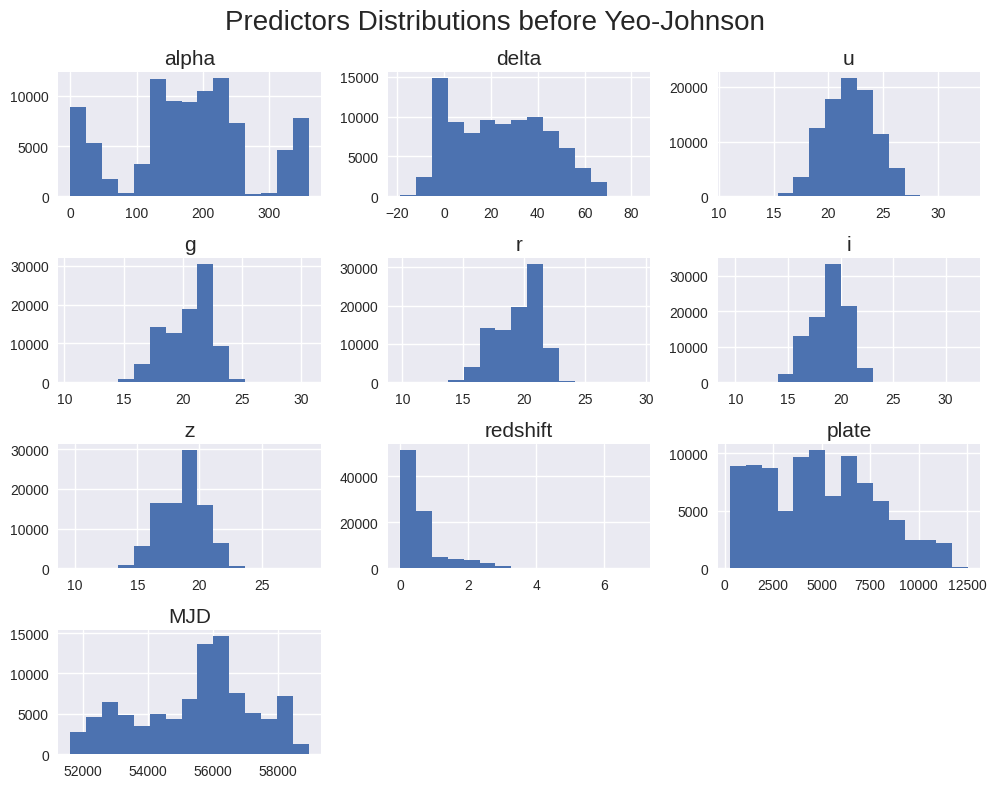

In [51]:
print("Prior Predictors' Skewness")
display(filtered_data.skew(numeric_only=True))

axes = filtered_data.hist(
    bins=15,
    figsize=(10,8)
)
for ax in axes.flatten():  
    ax.set_title(ax.get_title(), fontsize=15)
plt.suptitle("Predictors Distributions before Yeo-Johnson", fontsize=20)
plt.tight_layout()
plt.show()


The Yeo–Johnson transformation, implemented in Scikit-Learn’s PowerTransformer, was applied to reduce skewness and make the predictor distributions more symmetric. This method estimates an optimal power parameter λ for each feature and can operate on both positive and negative values. After transformation, all variables were standardized in the same funcion, which subtracts the mean and divides by the standard deviation so that each feature has zero mean and unit variance.

Here is the Yeo-Johnson technique implemented:
$$
x^{(\lambda)} =
\begin{cases}
\frac{(x + 1)^{\lambda} - 1}{\lambda}, & \text{if } x \ge 0,\ \lambda \neq 0, \\[10pt]
\ln(x + 1), & \text{if } x \ge 0,\ \lambda = 0, \\[10pt]
-\frac{(-x + 1)^{2 - \lambda} - 1}{2 - \lambda}, & \text{if } x < 0,\ \lambda \neq 2, \\[10pt]
-\ln(-x + 1), & \text{if } x < 0,\ \lambda = 2.
\end{cases}
$$



In [52]:
from sklearn.preprocessing import PowerTransformer

# Keep output classes
outputs = ["redshift", "class"]
X = filtered_data.drop(outputs, axis=1)
predictors = X.columns

# Apply Yeo-Johnson + Normalization on predictors
pt = PowerTransformer(method='yeo-johnson', standardize=True)
symmetric_data = pd.DataFrame(pt.fit_transform(X), columns=predictors)

symmetric_data = pd.concat([symmetric_data, filtered_data[outputs]], axis=1)
symmetric_data

,alpha,delta,u,g,r,i,z,plate,MJD,redshift,class
0,0.041003,-1.456383,-1.097199,-1.283541,-1.305148,-1.293686,-1.294214,-2.019336,-1.611443,0.103041,GALAXY
1,0.589494,-1.085375,1.743821,1.074022,0.878021,0.614134,0.465749,-0.159829,-0.138387,0.558141,GALAXY
2,-1.800833,-0.759922,-0.184567,0.232911,0.474385,0.739638,0.954071,1.810490,1.848536,1.273338,QSO
3,0.508051,1.233004,-2.014692,-1.914424,-1.901497,-1.979147,-1.994504,-1.324736,-1.438254,0.065335,GALAXY
4,0.416818,-0.057719,-1.530580,-1.727890,-1.831008,-1.918972,-1.983469,-0.646017,-0.585896,0.075291,GALAXY
...,...,...,...,...,...,...,...,...,...,...,...
92298,0.320380,-1.246897,-0.363346,-0.733492,-1.002304,-1.011294,-1.026334,-2.049928,-1.901075,0.235709,GALAXY
92299,-0.431021,1.385941,-1.931655,-1.752904,-1.658608,-1.579780,-1.466684,-0.840728,-0.977478,0.000262,STAR
92300,-0.516209,0.885084,0.114251,0.652254,1.280672,1.803149,1.558766,-0.248476,-0.055131,1.070947,QSO
92301,1.581990,-0.063318,1.021237,0.933069,0.540205,0.266399,0.115003,0.508079,0.341978,0.543487,GALAXY


Transformed Predictors' Skewness


alpha      -0.297701
delta      -0.263139
u          -0.018514
g          -0.079445
r          -0.070713
i          -0.029252
z          -0.027431
plate      -0.167510
MJD        -0.055400
redshift    2.503951
dtype: float64

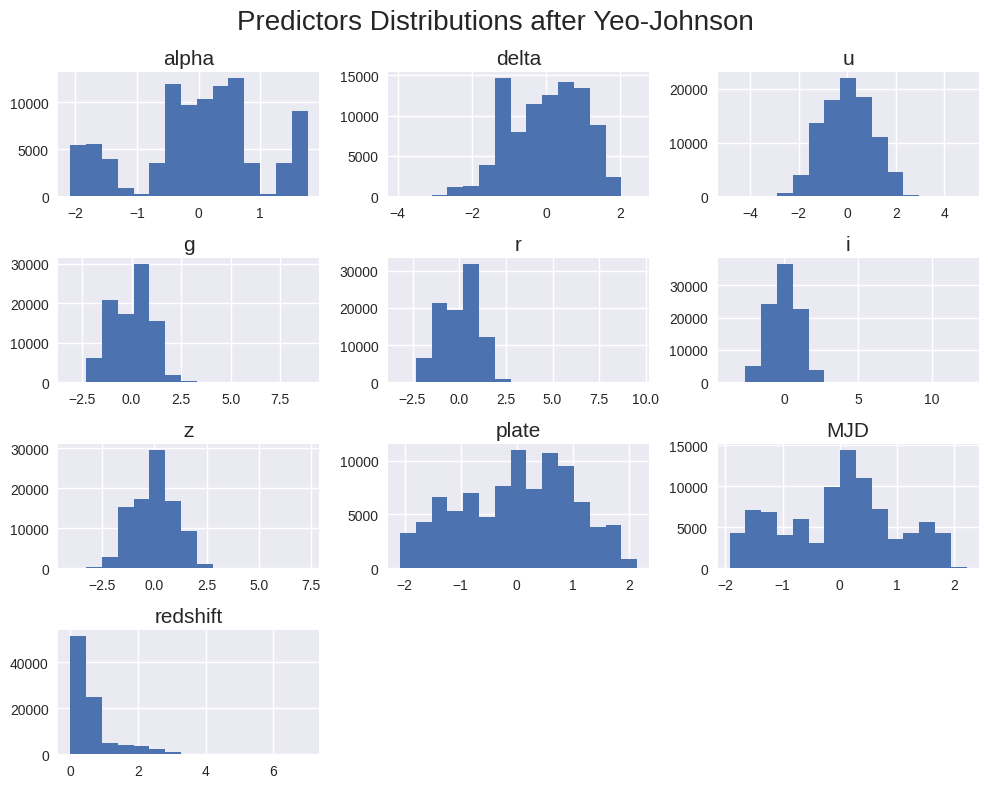

In [53]:
print("Transformed Predictors' Skewness")
display(symmetric_data.skew(numeric_only=True))

axes = symmetric_data.hist(
    bins=15,
    figsize=(10,8)
)
for ax in axes.flatten():  
    ax.set_title(ax.get_title(), fontsize=15)
plt.suptitle("Predictors Distributions after Yeo-Johnson", fontsize=20)
plt.tight_layout()
plt.show()

## 3 Correlation Analysis

### 3.1 Predictor–Predictor Correlation

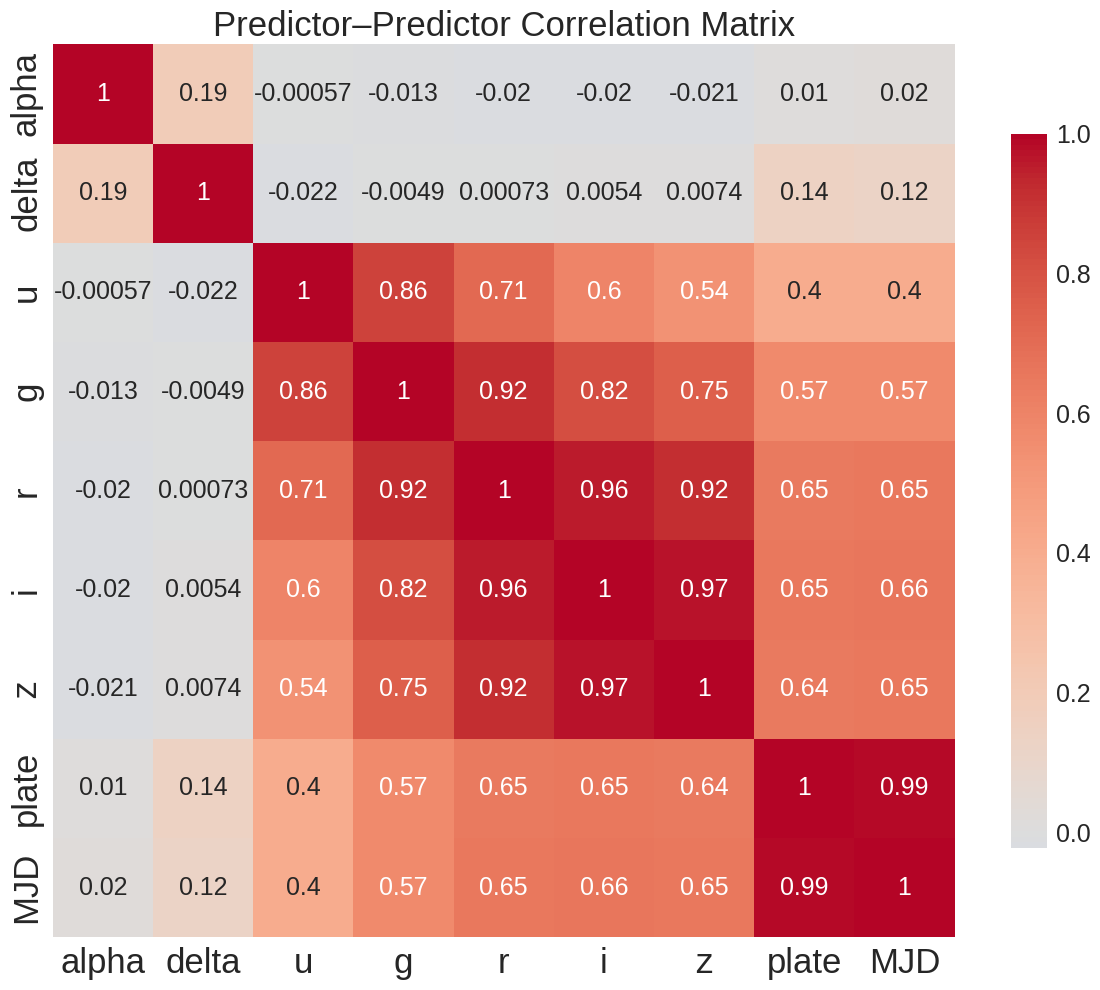

In [54]:
X = symmetric_data.drop(["redshift", "class"], axis=1)
y = symmetric_data["redshift"]

corr_matrix = X.corr(method="pearson")

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    annot_kws={"size": 18},   
    cbar_kws={"shrink": 0.8}, 
)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
plt.title("Predictor–Predictor Correlation Matrix",fontsize=25)
plt.tight_layout()
#plt.savefig("../img/corr_matrix.pdf")
plt.show()

### 3.2 Predictor-Outcome Correlations


Predictor–Outcome Correlations (sorted by absolute value):

z        0.523507
i        0.514696
r        0.443887
MJD      0.395980
plate    0.389927
g        0.305669
u        0.162423
delta    0.038622
alpha    0.002278
dtype: float64


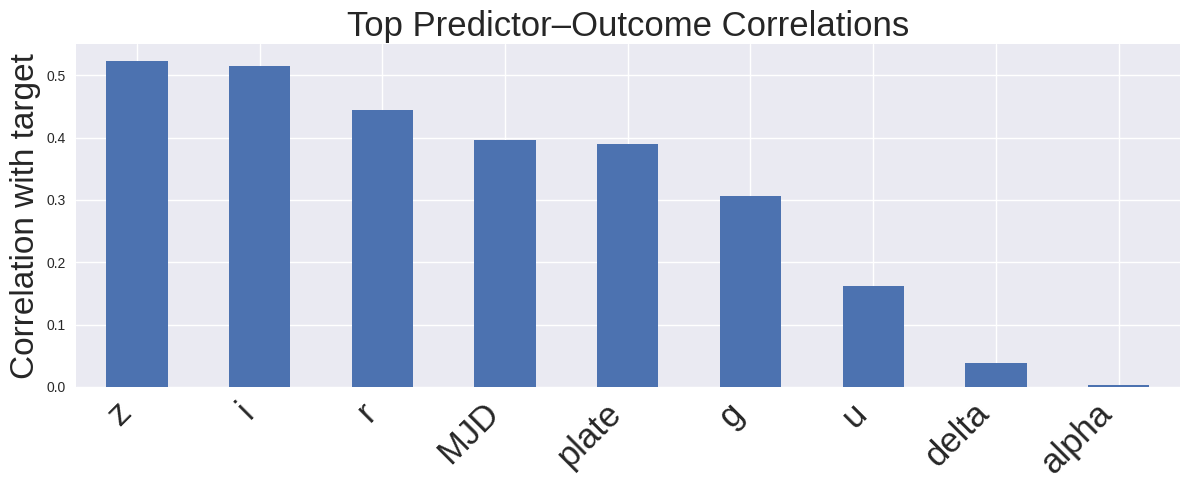

In [55]:
y_corr = X.apply(lambda col: col.corr(y))    # correlation of each predictor with target
y_corr_sorted = y_corr.abs().sort_values(ascending=False)

print("\nPredictor–Outcome Correlations (sorted by absolute value):\n")
print(y_corr_sorted)

plt.figure(figsize=(12, 5))
y_corr_sorted.plot(kind='bar')
plt.title("Top Predictor–Outcome Correlations", fontsize=25)
plt.ylabel("Correlation with target", fontsize=24)
plt.xticks(fontsize=25, rotation=45, ha='right')
plt.tight_layout()
#plt.savefig("../img/top_pred.pdf")
plt.show()

### 3.3 Removing Irrelevant Predictors

Removing alpha and delta, as they exhibit no significant correlation with the outcome.

Removing plate and MJD, as they are instrumental variables.

All photometric variables were retained, as classification studies on stellar objects consistently rely on and preserve these features.

In [56]:
final_data = symmetric_data.drop(["alpha", "delta", "plate", "MJD"], axis=1)
final_data.to_csv("../data/preprocessed_data.csv", index=False)
final_data.head(30)

,u,g,r,i,z,redshift,class
0,-1.097199,-1.283541,-1.305148,-1.293686,-1.294214,0.103041,GALAXY
1,1.743821,1.074022,0.878021,0.614134,0.465749,0.558141,GALAXY
2,-0.184567,0.232911,0.474385,0.739638,0.954071,1.273338,QSO
3,-2.014692,-1.914424,-1.901497,-1.979147,-1.994504,0.065335,GALAXY
4,-1.530580,-1.727890,-1.831008,-1.918972,-1.983469,0.075291,GALAXY
5,1.869488,1.086371,1.907968,2.281564,2.227850,-0.000647,STAR
6,0.269537,0.661422,1.244155,1.689420,1.529267,0.003898,STAR
7,-0.899442,-1.427580,-1.574870,-1.599435,-1.564741,0.000067,STAR
8,0.263246,-0.709158,-0.966073,-1.054904,-1.142423,0.154675,GALAXY
9,0.575219,1.782033,1.131481,0.785426,0.478584,0.705566,GALAXY
